In [2]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import optimize
import DCM
import pickle

In [3]:
df_raw = pd.read_excel('../ALP/alp481/ms481_weighted.xlsx')
df_raw = df_raw[df_raw['reward'] >=0]

# Questions about stock holding
for var in ['q3','q4','q6','q7','q12','q13','q15','q16']:
    df_raw[var] = df_raw[var].fillna(0)

# Some participants do not recall the exact amounts
# These participants are directed to a follow-up question: selecting from pre-defined ranges  
# rough_stock_holding = {1:0, 2: 500, 3: 2500, 4: 5000, 5: 10000, 6:30000, 7:100000, 8:200000}

rough_stock_holding = {
    1: (0, 500),
    2: (501, 2500),
    3: (2501, 5000),
    4: (5001, 10000),
    5: (10001, 30000),
    6: (30001, 100000),
    7: (100001, 200000),
    8: (200000, np.inf) 
}

'''
    1 Between $0 and $500 
    2 Between $501 and $2,500 
    3 Between $2,501 and $5,000
    4 Between $5,001 and $10,000 
    5 Between $10,001 and $30,000 
    6 Between $30,001 and $100,000 
    7 Between $100,001 and $200,000 
    8 More than $200,000
'''

# Impute stock holding amounts by median of the collected exact amounts within the corresponding range
wealth_vars = {'q3': 'fund', 'q6':'indiv_stock', 'q12':'retire_fund', 'q15':'retire_stock'}
impute_holding = np.repeat(0, len(df_raw))

for var in ['q3','q6','q12','q15']:

    rough_var = 'q'+str(int(var[1:]) + 1)

    for hold_level in range(1,9):
        lower, upper = rough_stock_holding[hold_level]

        holding = df_raw[(df_raw[var] > lower) & (df_raw[var] <= upper)][var].median()
        
        impute_holding = impute_holding + holding * (df_raw[rough_var] == hold_level)

    df_raw[wealth_vars[var]] = df_raw[var].fillna(0) + impute_holding.fillna(0)

# Ratio of equity in individual stocks
df_raw['ratio_indiv_stock'] = df_raw['indiv_stock'] / (df_raw['indiv_stock'] + df_raw['fund'])

# Total financial wealth
df_raw['fin_wealth'] = df_raw['indiv_stock'] + df_raw['fund'] + df_raw['retire_stock'] + df_raw['retire_fund']


# Get the variables for the risky choices
# Each variable is formed as '{Task}_{Round}_{Node number}'
# For example, 'a2_2_2' implies Task a2, Round 2, Node 2
q_risk_vars = []
for var in df_raw.columns:
    if var.startswith('a') and len(var) > 1 and var[1].isdigit():
        q_risk_vars.append(var)

# Remove multiple choices
# Round 1: if choice = 1, must jump to Node 3; if choice = 2, must jump to Node 2
# Round 2, Node 2: if choice = 1, must jump to Node 5; if choice = 2, must jump to Node 4
# Round 2, Node 3: if choice = 1, must jump to Node 7; if choice = 2, must jump to Node 6
for q in q_risk_vars:

    q_round = int(q.split('_')[1])

    if q_round in [1,2]:
        q_loc = int(q.split('_')[2])
        if q_loc == 1:
            current_choice = df_raw[f"{q.split('_')[0]}_{q_round}_{q_loc}"]
            df_raw.loc[current_choice == 1, f"{q.split('_')[0]}_{q_round+1}_2"] == np.nan
            df_raw.loc[current_choice == 2, f"{q.split('_')[0]}_{q_round+1}_3"] == np.nan
        if q_loc == 2:
                current_choice = df_raw[f"{q.split('_')[0]}_{q_round}_{q_loc}"]
                df_raw.loc[current_choice == 1, f"{q.split('_')[0]}_{q_round+1}_4"] == np.nan
                df_raw.loc[current_choice == 2, f"{q.split('_')[0]}_{q_round+1}_5"] == np.nan
        if q_loc == 3:
                current_choice = df_raw[f"{q.split('_')[0]}_{q_round}_{q_loc}"]
                df_raw.loc[current_choice == 1, f"{q.split('_')[0]}_{q_round+1}_6"] == np.nan
                df_raw.loc[current_choice == 2, f"{q.split('_')[0]}_{q_round+1}_7"] == np.nan


# Calculate the choices for each specific question
prefixes = list(set(col.rsplit('_', 1)[0] for col in q_risk_vars))

for prefix in prefixes:
    matching_cols = [col for col in q_risk_vars if col.startswith(prefix)]
    df_raw[prefix] = df_raw[matching_cols].bfill(axis=1).iloc[:, 0]

# Each row is an indidvidual-choice dyad
df_risk_choice = df_raw[['prim_key']+prefixes].melt(id_vars='prim_key', var_name='q_risk', value_name='choice')

# Only keep the participants who complete all 6 Probabilty Weighting (PW) tasks 
pw_tasks = ['a7', 'a8', 'a9', 'a10', 'a11', 'a12']
pw_criteria = df_risk_choice['q_risk'].str.startswith(tuple(pw_tasks)) & \
                df_risk_choice['q_risk'].str.split('_').str[1].isin(['1','2','3'])

df_check = df_risk_choice[pw_criteria].groupby('prim_key').count()['choice']

df_risk_choice = df_risk_choice[df_risk_choice['prim_key'].isin(df_check[df_check == 18].index)]

print('Number of participants who complete all PW tasks:',len(df_risk_choice['prim_key'].unique()))

Number of participants who complete all PW tasks: 2671


In [4]:
df_risk_task = df_risk_choice[df_risk_choice['q_risk'].str.split('_').str[1].isin(['1','2','3'])]
df_risk_task['q_task'] = df_risk_task['q_risk'].str.split('_').str[0]
df_risk_task['q_round'] = df_risk_task['q_risk'].str.split('_').str[1]

# Each row is an individual-task dyad
df_risk_task = df_risk_task.pivot_table(
    index = ['prim_key','q_task'],
    columns = 'q_round',
    values = 'choice'
).reset_index()

df_risk_task.columns = ['prim_key','q_task','round1_choice','round2_choice','round3_choice']

# Import the Bi-Section Paths for all tasks
# choice = 1: Option A; choice = 2: Option B
df_all_tasks = pd.read_csv('../ALP/alp481/all_tasks.csv').iloc[:,1:]
df_all_tasks.replace({'A':1, 'B':2}, inplace=True)

df_risk_task = pd.merge(left = df_risk_task, right = df_all_tasks, on = ['q_task','round1_choice','round2_choice','round3_choice'])
df_risk_task['premium'] = df_risk_task['premium'].str.strip('%').astype(float) /100

# Probability Weighting (PW) task: a7, a9, a11 (underweight), a8, a10, a12 (overweight)
# Risk Aversion (RA) task: a2, a3, a4, a5
df_inverseS_1 = df_risk_task[df_risk_task['q_task'].isin(['a7','a9','a11'])].groupby('prim_key')['premium'].sum()
df_inverseS_2 = df_risk_task[df_risk_task['q_task'].isin(['a8','a10','a12'])].groupby('prim_key')['premium'].sum()
df_inverseS_3 = df_risk_task[df_risk_task['q_task'].isin(['a2','a3','a4','a5'])].groupby('prim_key')['premium'].mean()

df_inverseS_1 = df_inverseS_1.reset_index().rename(columns={'premium':'underweight'})
df_inverseS_2 = df_inverseS_2.reset_index().rename(columns={'premium':'overweight'})
df_inverseS_3 = df_inverseS_3.reset_index().rename(columns={'premium':'riskaversion'})

df_inverseS = pd.merge(df_inverseS_1, df_inverseS_2, on='prim_key', how='inner')
df_inverseS = pd.merge(df_inverseS, df_inverseS_3, on='prim_key', how='inner')

df_inverseS['inverse_S'] = df_inverseS['underweight'] - df_inverseS['overweight']
df_inverseS

C:\Users\phd19zw1\AppData\Local\Temp\ipykernel_9828\1594690173.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_risk_task['q_task'] = df_risk_task['q_risk'].str.split('_').str[0]
C:\Users\phd19zw1\AppData\Local\Temp\ipykernel_9828\1594690173.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_risk_task['q_round'] = df_risk_task['q_risk'].str.split('_').str[1]
C:\Users\phd19zw1\AppData\Local\Temp\ipykernel_9828\1594690173.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will

,prim_key,underweight,overweight,riskaversion,inverse_S
0,10017494:1,1.594,0.002,0.30300,1.592
1,10018010:1,-0.102,0.412,-0.01275,-0.514
2,10027497:1,0.677,-0.637,0.01275,1.314
3,10027500:1,1.886,1.036,0.25650,0.850
4,10027505:1,0.858,0.052,-0.20050,0.806
...,...,...,...,...,...
2666,9117485:1,0.174,0.365,0.49675,-0.191
2667,9117486:1,0.802,1.036,0.28925,-0.234
2668,9117488:1,-0.484,0.656,0.23975,-1.140
2669,9117489:1,1.594,0.859,-0.07025,0.735


In [5]:
covariates = ['gender', #1 Male 2 Female
 'calcage', #age
 'currentlivingsituation', # 1 Married, 2 Separated, 3 Divorced, 4 Widowed, 5 Never married
 'ethnicity', #1 White, 2 Black, 3 American Indian or Alaskan Native, 4 Asian or Pacific Islander, 5 Other
 'hispaniclatino', #1 Yes, 2 No
 'householdmembers',
 'currentjobstatuss1', #1 Employed, NaN Other
 'highesteducation', #1 Less than 1st grade, 2 1-4th grade, 3 5-6th grade, 4 7-8th grade, 5 9th grade, 6 10th grade, 7 11th grade, 8 12th grade NO DIPLOMA, 9 HIGH SCHOOL GRADUATE, 10 Some college but no degree, 11 Associate degree in college Occupational/vocational program, 12 Associate degree in college Academic program, 13 Bachelor's degree, 14 Master's degree, 15 Professional School Degree, 16 Doctorate degree
 'familyincome', #1 Less than $5,000 2 $5,000 to $7,499 3 $7,500 to $9,999 4 $10,000 to $12,499 5 $12,500 to $14,999 6 $15,000 to $19,999 7 $20,000 to $24,999 8 $25,000 to $29,999 9 $30,000 to $34,999 10 $35,000 to $39,999 11 $40,000 to $49,999 12 $50,000 to $59,999 13 $60,000 to $74,999 14 $75,000 or more
 'familyincome_part2', #1 $75,000-$99,999 2 $100,000-$124,999 3 $125,000-$199,999 4 $200,000 or more
 'q19', #buy a lottery ticket, play at a casino, play a slot machine, or bet online in the last 3 months. 1 Yes, 2 No
 'q20', #Financial Literacy (interest): correct = 1
 'q21', #Financial Literacy (inflation): correct = 3
 'q22', #Financial Literacy (diversification): correct = 2
 'q23', #Numeracy (1): correct = 3
 'q24', #Numeracy (2): correct = 2
 'q25', #Numeracy (3): correct = 2
 'q26', #Trust 0-5: 0 Most people can be trusted, 5 you can’t be too careful in dealing with people
 'q27', #How long do you think you will live? Puri and Robinson (2007)
 ]

# Merge stock holding data and risky choice data
df_reg = pd.merge(left = df_raw[['prim_key','weight','ratio_indiv_stock','fin_wealth'] + covariates], 
                  right= df_inverseS,
                  on='prim_key')

df_reg = df_reg.rename(columns = {'calcage': 'age', 'q26':'trust'})

# optimism: difference between self-reported and estimated life expectancy
df_mortality = pd.read_csv('../ALP/alp481/mortality_table.csv')

def life_expectancy(age,gender): 

    round_floor = np.floor(age / 5) * 5
    round_ceil = np.ceil(age / 5) * 5

    floor_diff = np.abs(age - round_floor)
    ceil_diff = np.abs(age - round_ceil)

    nearest = np.where(floor_diff <= ceil_diff, round_floor, round_ceil)

    gender_encode = {1:'male',2:'female'}
    gender_label = gender_encode.get(gender)

    life_exp = df_mortality[df_mortality['age'] == nearest][gender_label] + nearest

    return life_exp.values[0]

df_reg['life_exp'] = df_reg.apply(lambda row: life_expectancy(row['age'], row['gender']), axis=1)
df_reg['optimism'] = df_reg['q27'] - df_reg['life_exp']

# gender, married, white, hispanic, employed, gambling, age
df_reg['male'] = df_reg['gender'] == 1
df_reg['married'] = df_reg['currentlivingsituation'] == 1
df_reg['white'] = df_reg['ethnicity'] == 1
df_reg['hispanic'] = df_reg['hispaniclatino'] == 1
df_reg['employed'] = df_reg['currentjobstatuss1'] == 1
df_reg['gambling'] = df_reg['q19'] == 1

df_reg['age2'] = df_reg['age']**2
df_reg['age_group'] = np.floor(df_reg['age'] / 10) * 10

# education
df_reg['no_college_degree'] = df_reg['highesteducation'] <= 10
df_reg['bachelor_degree'] = df_reg['highesteducation'].between(11,13)
df_reg['master_degree'] = df_reg['highesteducation'].between(14,16)

# financial literacy & numeracy
df_reg['fin_literacy'] = (df_reg['q20'] == 1) + (df_reg['q21'] == 3) + (df_reg['q22'] == 2)
df_reg['numeracy'] = (df_reg['q23'] == 3) + (df_reg['q24'] == 2) + (df_reg['q25'] == 2)

# family income & financial wealth
df_reg['familyincome_rank'] = (df_reg['familyincome_part2'] - 1).fillna(0) + df_reg['familyincome'].fillna(0)

income_lower = {1: 0, 2: 5000, 3: 7500, 4: 10000, 5: 12500, 6: 15000,
                7: 20000, 8: 25000, 9: 30000, 10: 35000, 11: 40000, 12: 50000, 13: 60000,
                14: 75000, 15: 100000, 16: 125000, 17: 200000}

df_reg['familyincome_value'] = df_reg.apply(lambda row: income_lower.get(row['familyincome_rank']),axis=1) / 1e3
df_reg['fin_wealth'] = df_reg['fin_wealth'] / 1e3

df_reg = df_reg.astype({col: 'int' for col in df_reg.columns if df_reg[col].dtype == 'bool'})

# Control variables
exog_cols = [
            'inverse_S','riskaversion',
             'age','age2',
             'age_group','male',
             'married','white','hispanic','employed','householdmembers',
             'no_college_degree','bachelor_degree','master_degree',
             'familyincome_value',
             'fin_wealth',
             'fin_literacy','numeracy','trust',
             'optimism',
             'gambling'
             ]

# Some participants report "don't know" for q27 (optimism) and family income, which creates NAs.
# Impute missing values with the group median 
df_reg['missing_value'] = df_reg.isna().any(axis=1).astype(int)

demographic_group = ['age_group','male','no_college_degree','bachelor_degree','master_degree']

impute_optimism = df_reg.groupby(demographic_group)['optimism'].median().reset_index()
impute_familyincome = df_reg.groupby(demographic_group)['familyincome_value'].median().reset_index()

df_reg = pd.merge(df_reg, impute_optimism, on=demographic_group, how='left', suffixes=('', '_imputed'))
df_reg = pd.merge(df_reg, impute_familyincome, on=demographic_group, how='left', suffixes=('', '_imputed'))
df_reg['optimism'] = df_reg['optimism'].fillna(df_reg['optimism_imputed'])
df_reg['familyincome_value'] = df_reg['familyincome_value'].fillna(df_reg['familyincome_value_imputed'])

exog_cols.remove('age_group')
exog_cols = exog_cols + ['missing_value']

# Only keep the individuals who hold equities 
df_reg = df_reg[~df_reg['ratio_indiv_stock'].isna()]
df_reg = df_reg[['prim_key','weight','ratio_indiv_stock']+exog_cols]

valid_prim_keys = df_reg['prim_key']
print("Number of participants in the regression sample:", len(valid_prim_keys))

# Standardize all non-binary variables (except age)
for var in ['inverse_S','riskaversion','householdmembers',
             'familyincome_value','fin_wealth',
             'fin_literacy','numeracy','trust','optimism']:
    df_reg[var] = (df_reg[var] - df_reg[var].mean()) / df_reg[var].std()

Number of participants in the regression sample: 741


In [6]:
endog = df_reg['ratio_indiv_stock']
exog = sm.add_constant(df_reg[exog_cols])

reg_result = sm.WLS(endog, exog, weights=df_reg['weight']).fit()
reg_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:      ratio_indiv_stock   R-squared:                       0.107
Model:                            WLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     4.301
Date:                Sat, 18 Jan 2025   Prob (F-statistic):           1.61e-09
Time:                        01:34:03   Log-Likelihood:                -464.79
No. Observations:                 741   AIC:                             971.6
Df Residuals:                     720   BIC:                             1068.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3198      0.125      2.565      0.011       0.075       0.565
inverse_S              0.0078      0.015      0.529      0.597      -0.021       0.037
riskaversion          -0.0032      0.015     -0.212      0.832      -0.033       0.026
age                    0.0067      0.006      1.105      0.269      -0.005       0.019
age2               -6.271e-05   5.91e-05     -1.061      0.289      -0.000    5.33e-05
male                   0.0767      0.031      2.487      0.013       0.016       0.137
married               -0.0359      0.036     -0.985      0.325      -0.107       0.036
white                 -0.1193      0.049     -2.456      0.014      -0.215      -0.024
hispanic               0.0857      0.064      1.343      0.180      -0.040       0.211
employed              -0.0358      0.045     -0.798      0.425      -0.124       0.052
householdmembers      -0.0161      0.014     -1.110      0.267      -0.045       0.012
no_college_degree      0.1594      0.048      3.347      0.001       0.066       0.253
bachelor_degree        0.1272      0.046      2.790      0.005       0.038       0.217
master_degree          0.0332      0.048      0.688      0.492      -0.062       0.128
familyincome_value     0.0506      0.019      2.604      0.009       0.012       0.089
fin_wealth            -0.0335      0.008     -4.070      0.000      -0.050      -0.017
fin_literacy          -0.0182      0.016     -1.150      0.250      -0.049       0.013
numeracy               0.0371      0.014      2.677      0.008       0.010       0.064
trust                  0.0269      0.015      1.789      0.074      -0.003       0.056
optimism              -0.0467      0.011     -4.177      0.000      -0.069      -0.025
gambling               0.0109      0.030      0.362      0.717      -0.048       0.070
missing_value          0.0083      0.045      0.182      0.856      -0.081       0.097
==============================================================================
Omnibus:                        0.863   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.649   Jarque-Bera (JB):                0.870
Skew:                          -0.083   Prob(JB):                        0.647
Kurtosis:                       2.974   Cond. No.                     1.19e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.95e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

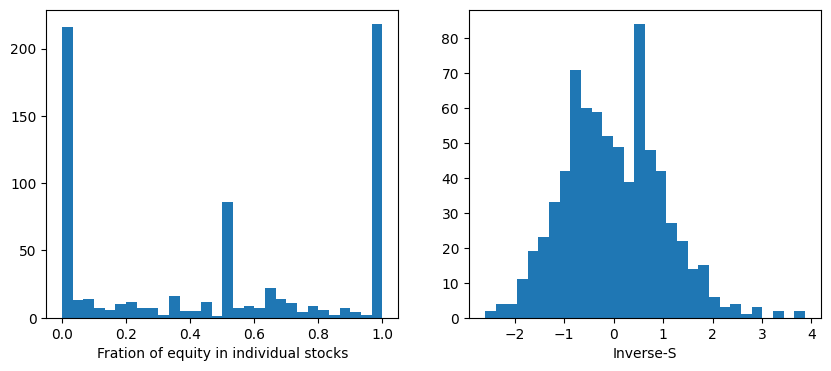

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.hist(df_reg['ratio_indiv_stock'],bins=30)
ax1.set_xlabel('Fration of equity in individual stocks')

ax2.hist(df_reg['inverse_S'],bins=30)
ax2.set_xlabel('Inverse-S')

plt.show()

In [8]:
# Tobit model
X = exog
y = endog
weights = df_reg['weight']
reg_var_names = reg_result.params.index
init_beta = reg_result.params.values
init_sigma = 1.0

# Weighted Tobit log-likelihood
def weighted_tobit_loglike(params, X, y, weights):
    beta = params[:-1]  
    sigma = params[-1]  
    y_star = X @ beta 

    ll = np.where(
        y == 0,
        st.norm.logcdf(- y_star / sigma),  # left-truncated
        np.where(
            y == 1,
            st.norm.logcdf((y_star - 1) / sigma),  # right-truncated
            st.norm.logpdf((y - y_star) / sigma) - np.log(sigma)  # uncensored
        )
    )
    return -np.sum(weights * ll)  # objective

# Initial parameters (beta, sigma)
initial_params = np.append(init_beta, init_sigma)

# Optimization
tobit_result = optimize.minimize(weighted_tobit_loglike, initial_params, 
                           args=(X, y, weights), 
                           method='L-BFGS-B')

# F-test
# Restricted model
X_restricted = np.ones((len(y), 1))  # Only intercept
init_params_restricted = np.append(init_beta[0], init_sigma)  # (intercept, sigma)

result_restricted = optimize.minimize(weighted_tobit_loglike, init_params_restricted, 
                             args=(X_restricted, y, weights), 
                             method='L-BFGS-B')

# Calculate LR statistics
LR = -2 * (result_restricted.fun - tobit_result.fun)
diff_dof = exog.shape[1] - X_restricted.shape[1] # difference in degree of freedom

p_value_f = st.chi2.sf(LR, diff_dof)
print(f"LR: {LR:.4f}, Degree of freedom: {diff_dof}, p-value: {p_value_f:.4f}")

#Pseudo R²
pseudo_r2 = 1 - (tobit_result.fun / result_restricted.fun)
print(f"Pseudo R²: {pseudo_r2:.4f}")

# t-tests
# Hessian matrix
hessian_inv = tobit_result.hess_inv.todense() 
standard_errors = np.sqrt(np.diag(hessian_inv))
t_values = tobit_result.x / standard_errors
p_values = [2 * (1 - st.t.cdf(np.abs(t), df=(len(y) - exog.shape[1] - 1))) for t in t_values]

# write the t-test results
t_test_result = {'variable':np.append(reg_var_names,'sigma'),
                 'coef': tobit_result.x,
                 'se': standard_errors,
                 't': t_values,
                 'p': p_values}

print(pd.DataFrame(t_test_result))

C:\Users\phd19zw1\AppData\Local\Temp\ipykernel_9828\4011409852.py:21: RuntimeWarning: invalid value encountered in log
  st.norm.logpdf((y - y_star) / sigma) - np.log(sigma)  # uncensored


LR: -60.3954, Degree of freedom: 21, p-value: 1.0000
Pseudo R²: 0.0510
              variable      coef          se         t         p
0                const  0.322721   14.496817  0.022261  0.982246
1            inverse_S  0.017591   18.570437  0.000947  0.999244
2         riskaversion -0.013507  135.001507 -0.000100  0.999920
3                  age  0.011070   88.823064  0.000125  0.999901
4                 age2 -0.000105    1.416463 -0.000074  0.999941
5                 male  0.142710  109.869066  0.001299  0.998964
6              married -0.086825  258.561079 -0.000336  0.999732
7                white -0.200257  309.269407 -0.000648  0.999484
8             hispanic  0.159942  263.197676  0.000608  0.999515
9             employed -0.068143   78.964815 -0.000863  0.999312
10    householdmembers -0.039340  344.851640 -0.000114  0.999909
11   no_college_degree  0.199287  257.543954  0.000774  0.999383
12     bachelor_degree  0.166457   17.327532  0.009606  0.992338
13       master_deg

In [10]:
# RA tasks
# Option A: win $[a_amount_1] with 33% chance, or else $[a_amount_2] with 67% chance.
# Option B: win $X with 33% chance 
ra_prob_a = [np.array([0.33,0.67])]*4
ra_prob_b = [0.33]*4
ra_amount_a = [np.array(a) for a in [[12,3],[18,3],[24,3],[30,3]]]

# PW tasks
# Option A: win $42 with [a_prob] chance, or else $6 with [1-a_prob] chance.
# Option B: win $X for sure
pw_prob_a = [np.array([p,1-p]) for p in [0.5,0.25,0.75,0.12,0.88,0.05]]
pw_prob_b = [1]*6
pw_amount_a = [np.array([42,6])]*6

task_list = ['a2','a3','a4','a5','a7', 'a8', 'a9', 'a10', 'a11', 'a12']

task_setup = {'q_task': task_list,
              'prob_a': ra_prob_a + pw_prob_a,
              'prob_b': ra_prob_b + pw_prob_b,
              'amount_a': ra_amount_a + pw_amount_a}

# Create variables for these attributes
df_risk = pd.merge(left = df_risk_task,
                    right = pd.DataFrame(task_setup),
                    on = 'q_task')

for var in ['prob_a','prob_b','amount_a']:
    df_risk[f'round1_{var}'] = df_risk[var]
    df_risk[f'round2_{var}'] = df_risk[var]
    df_risk[f'round3_{var}'] = df_risk[var]

# Each row represents an individual
df_risk = df_risk.pivot_table(index = 'prim_key',
                    columns = 'q_task',
                    values = [col for col in df_risk.columns if 'round' in col],
                    aggfunc='first')

df_risk.columns = [f'{task}_{col}' for col, task in df_risk.columns]
df_risk = df_risk[sorted(df_risk.columns)][[col for col in df_risk.columns if 'round' in col]].reset_index()

# Relabel: 1 = choosing option A, 0 = choosing option B
choice_cols = [col for col in df_risk.columns if 'choice' in col]
df_risk[choice_cols] = 2 - df_risk[choice_cols]

df_equity = pd.merge(left = df_reg[['prim_key','weight']],right = df_risk,on='prim_key').dropna()
print('Number of participants for model estimation:',len(df_equity))

# Specify x1, x2, p1, p2
p_a = [col for col in df_equity.columns if 'prob_a' in col]
p_b = [col for col in df_equity.columns if 'prob_b' in col]
x_a = [col for col in df_equity.columns if 'amount_a' in col]
x_b = [col for col in df_equity.columns if 'x' in col]

# df_risk[x_b].astype(float)

Number of participants for model estimation: 737


In [11]:
bounds = [(0,1),(0,1),(0,None)]

model = DCM.mixedDiscrete(data=df_equity,
                choice = choice_cols,
                x1 = x_a,
                x2 = x_b,
                p1 = p_a,
                p2 = p_b)

model.set_init_param(param_keys=['riskCoef','probW','temp'],
                     param_init=[0.5,0.5,1],
                     weight = df_equity['weight'].values)

model.fit_param(bounds=bounds)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 11415351.137729723
        x: [ 3.364e-01  1.737e-01  1.380e+00]
      nit: 11
      jac: [ 5.029e+00 -1.118e+00 -1.118e+00]
     nfev: 48
     njev: 12
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [12]:
DCM.get_best_result(model,bounds,n_class=2,n_init_point=8,name_prefix='models_prob_weigh/pw',name_suffix='2param')

np.float64(10375.274925564987)

In [13]:
DCM.get_best_result(model,bounds,n_class=3,n_init_point=8,name_prefix='models_prob_weigh/pw',name_suffix='2param')

np.float64(10181.15292759154)

In [14]:
DCM.get_best_result(model,bounds,n_class=4,n_init_point=8,name_prefix='models_prob_weigh/pw',name_suffix='2param')

np.float64(10389.910145739797)

In [15]:
DCM.get_best_result(model,bounds,n_class=5,n_init_point=8,name_prefix='models_prob_weigh/pw',name_suffix='2param')

np.float64(9891.13953999787)

In [16]:
bounds = [(0,1),(0,1)]

model = DCM.mixedDiscrete(data=df_equity,
                choice = choice_cols,
                x1 = x_a,
                x2 = x_b,
                p1 = p_a,
                p2 = p_b,
                fixed_args ={'temp': 1.38})

model.set_init_param(param_keys=['riskCoef','probW'],
                     param_init=[0.5,0.5],
                     weight = df_equity['weight'].values)

model.fit_param(bounds=bounds)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 11415351.156314367
        x: [ 3.365e-01  1.737e-01]
      nit: 7
      jac: [-1.863e-01  0.000e+00]
     nfev: 30
     njev: 10
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [17]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 1.8],
                     n_class=2, n_init_point = 8, name_prefix = 'models_prob_weigh/pw')

Searching optimal value for temp
Step 1: 0.7333333333333333
Evaluation metrics: 11026.202998691657, 11211.180491725672
Step 2: 0.9111111111111111
Evaluation metrics: 11089.87984064133, 11040.626130675402
Step 3: 0.7925925925925926
Evaluation metrics: 11025.96713583033, 11057.002501251263
Step 4: 0.8716049382716049
Evaluation metrics: 11227.023337399845, 11033.809159805196
Step 5: 0.8189300411522633
Evaluation metrics: 11027.581486486903, 11197.328761860785
Step 6: 0.7838134430727024
Evaluation metrics: 11025.637205809016, 11030.980989741725
Step 7: 0.7604023776863282
Evaluation metrics: 11025.335194286426, 11205.937038661028
Step 8: 0.7447950007620789
Evaluation metrics: 11025.661016340375, 11208.306761322268
Step 9: 0.7551999187115785
Evaluation metrics: 11026.141847087521, 11025.393367868895
Step 10: 0.7482633067452454
Evaluation metrics: 11025.5509568436, 11213.953004860661


({'temp': 0.7482633067452454}, np.float64(11025.550055084097))

In [18]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 1.8],
                     n_class=3, n_init_point = 8, name_prefix = 'models_prob_weigh/pw')

Searching optimal value for temp
Step 1: 1.2666666666666666
Evaluation metrics: 11070.746372845992, 10935.416696551916
Step 2: 1.4444444444444446
Evaluation metrics: 10986.475689008812, 10968.276086196913
Step 3: 1.5629629629629629
Evaluation metrics: 11036.527068931988, 10990.6782196161
Step 4: 1.4839506172839507
Evaluation metrics: 11049.381121157723, 11063.790841445829
Step 5: 1.4312757201646091
Evaluation metrics: 10965.791677210396, 10985.706400635521
Step 6: 1.396159122085048
Evaluation metrics: 10959.187829935643, 10972.422889260843
Step 7: 1.3727480566986738
Evaluation metrics: 10954.809619489477, 10963.58644017959
Step 8: 1.3571406797744245
Evaluation metrics: 10951.905219091776, 10957.725948237317
Step 9: 1.3467357618249252
Evaluation metrics: 10949.976589793976, 10953.840145323014
Step 10: 1.339799149858592
Evaluation metrics: 10948.694537954772, 10951.261601137514


({'temp': 1.339799149858592}, np.float64(10948.69447434905))

In [19]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 1.8],
                     n_class=4, n_init_point = 8, name_prefix = 'models_prob_weigh/pw')

Searching optimal value for temp
Step 1: 1.2666666666666666
Evaluation metrics: 10867.120170438462, 10764.975883097179
Step 2: 1.088888888888889
Evaluation metrics: 10886.161855257136, 10968.154542487657
Step 3: 1.2074074074074075
Evaluation metrics: 10809.083962240924, 10754.958677536813
Step 4: 1.2864197530864199
Evaluation metrics: 10896.886714541266, 10768.460055855478
Step 5: 1.3390946502057615
Evaluation metrics: 10836.671321589329, 10777.822042109387
Step 6: 1.3039780521262003
Evaluation metrics: 10937.674557036129, 10953.666693307805
Step 7: 1.3273891175125745
Evaluation metrics: 10932.433759181487, 10775.72017596186
Step 8: 1.3117817405883252
Evaluation metrics: 10772.937440332184, 10778.478303104555
Step 9: 1.3221866585378246
Evaluation metrics: 10845.119976685455, 10774.746412570626
Step 10: 1.3152500465714918
Evaluation metrics: 10773.506811657762, 10776.031700758891


({'temp': 1.3152500465714918}, np.float64(10773.50208654423))

In [20]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 1.8],
                     n_class=5, n_init_point = 8, name_prefix = 'models_prob_weigh/pw')

Searching optimal value for temp
Step 1: 1.2666666666666666
Evaluation metrics: 10916.814080193244, 10764.864333768555
Step 2: 1.088888888888889
Evaluation metrics: 10667.605143585457, 10796.984415066063
Step 3: 0.9703703703703704
Evaluation metrics: 10705.753844310999, 10728.478439200826
Step 4: 1.0493827160493827
Evaluation metrics: 10692.990469866887, 10684.357932243774
Step 5: 1.1020576131687243
Evaluation metrics: 10866.186766997906, 10731.482951333946
Step 6: 1.0669410150891634
Evaluation metrics: 10724.285110202443, 10738.825096343586
Step 7: 1.0435299497027892
Evaluation metrics: 10719.594982944956, 10729.064748228628
Step 8: 1.02792257277854
Evaluation metrics: 10678.510331514772, 10732.353774357092
Step 9: 1.0175176548290403
Evaluation metrics: 10714.514900422708, 10718.566550124884
Step 10: 1.0105810428627073
Evaluation metrics: 10713.184490914018, 10715.853124286607


({'temp': 1.0105810428627073}, np.float64(10713.184435777392))

In [318]:
df_filtered = df_raw[['prim_key']+q_risk_vars].melt(id_vars = 'prim_key',
                                      var_name = 'q_risk',
                                      value_name = 'choice',
                                      value_vars = q_risk_vars).dropna()

df_filtered = df_filtered[df_filtered['q_risk'].str.split('_').str[1].eq('3')]
df_filtered = df_filtered[df_filtered['prim_key'].isin(valid_prim_keys)]

df_filtered['task'] = df_filtered['q_risk'].str.extract(r'a(\d+)').astype(int)
df_filtered['round3'] = df_filtered['q_risk'].str.split('_').str[2].astype(int)
df_filtered['rank'] = (df_filtered['round3'] - 4)*2 + (3 - df_filtered['choice'])
tab_count_all = df_filtered[['prim_key','task','rank']].dropna().groupby(['task','rank']).count().reset_index()

task_list = tab_count_all['task'].unique()

for i in range(len(task_list)):
    tab_count = tab_count_all[tab_count_all['task'] == task_list[i]].sort_values('rank')
    tab_count = tab_count[['rank','prim_key']].set_index('rank')['prim_key']
    tab_count.index = tab_count.index.astype(int).astype(str)

    result_prop_test = DCM.prop_test(tab_count,hide=True)
    prop_test_sort = sorted(result_prop_test[['p_lo_hi']].values.flatten(),reverse= True)
    
    print('task:',task_list[i],', p-value:',min(np.array(prop_test_sort) * np.arange(1,len(prop_test_sort)+1)))

task: 2 , p-value: 1.3779862742313282e-27
task: 3 , p-value: 6.153031092758909e-26
task: 4 , p-value: 1.1248669398773394e-21
task: 5 , p-value: 6.024142679574086e-23
task: 7 , p-value: 3.3769125805714923e-16
task: 8 , p-value: 2.347640357107383e-36
task: 9 , p-value: 3.082748063589614e-18
task: 10 , p-value: 1.2509563626555807e-22
task: 11 , p-value: 9.702562228849847e-07
task: 12 , p-value: 1.0343681241541295e-34


In [21]:
model = DCM.mixedNormal(data=df_equity,
                choice = choice_cols,
                x1 = x_a,
                x2 = x_b,
                p1 = p_a,
                p2 = p_b)

model.set_init_mixed(meta_param = {'mean':[0.1,0.1,0.1],'variance':[[1,0.1,0.1],[0.1,1,0.1],[0.1,0.1,1]]}, 
                     param_keys= ['riskCoef','probW','temp'],
                     dist_type=['johnson_sb','johnson_sb','lognormal'],
                     n_draws = 100,
                     n_batch = 10,
                     weight = df_equity['weight'].values)

model.runEM(max_iter=100,min_iter=10,excess_step=20)

c:\Users\phd19zw1\OneDrive - University of Warwick\preference_reanalysis\staircase\DCM.py:584: RuntimeWarning: divide by zero encountered in log
  self.obj_func = - np.sum(self.w * np.log(self.likeIndiv(const))) / self.n_random


Iteration 1
{'mean': [np.float64(-0.06133165555125591), np.float64(0.005372173717367307), np.float64(0.06953644158821008)], 'variance': array([[1.0929417 , 0.18131064, 0.44668446],
       [0.18131064, 0.9525198 , 0.15870932],
       [0.44668446, 0.15870932, 1.11783085]])}
gradient: (array([ 16.68627154,  -1.29494186, -17.02832158]), array([[ 94.22177748, -11.94410338, -35.95513821],
       [-11.94410338,  92.64739896,  -8.38119716],
       [-35.95513821,  -8.38119716,  91.3765177 ]]))
objective: inf
Iteration 2
{'mean': [np.float64(-0.08902370908749037), np.float64(-0.06781395134345967), np.float64(0.022015995445825325)], 'variance': array([[1.44274799, 0.28600306, 0.69982399],
       [0.28600306, 0.85933534, 0.15864289],
       [0.69982399, 0.15864289, 1.16866292]])}
gradient: (array([ 14.88434082,  10.93155107, -13.59028523]), array([[ 86.47083074, -19.71384354, -49.10475015],
       [-19.71384354, 105.65544945,  -2.53731433],
       [-49.10475015,  -2.53731433, 102.27065662]]))
obje

c:\Users\phd19zw1\OneDrive - University of Warwick\preference_reanalysis\staircase\DCM.py:584: RuntimeWarning: invalid value encountered in multiply
  self.obj_func = - np.sum(self.w * np.log(self.likeIndiv(const))) / self.n_random


Iteration 9
{'mean': [np.float64(-0.4058567087186077), np.float64(-0.16813548937893055), np.float64(-0.06264658681607392)], 'variance': array([[ 2.60344537,  0.0042986 ,  0.73060855],
       [ 0.0042986 ,  0.6416774 , -0.13544166],
       [ 0.73060855, -0.13544166,  0.98742088]])}
gradient: (array([27.33702245, 43.4912153 , -3.50732219]), array([[ 41.43726559,  -6.95038013, -31.61346123],
       [ -6.95038013, 137.18380485,  23.95980322],
       [-31.61346123,  23.95980322, 112.51021563]]))
objective: nan
Iteration 10
{'mean': [np.float64(-0.40892630520926415), np.float64(-0.17901444372527897), np.float64(-0.04707666077814151)], 'variance': array([[ 2.51776537, -0.05453586,  0.75032779],
       [-0.05453586,  0.60874342, -0.13458213],
       [ 0.75032779, -0.13458213,  0.9910637 ]])}
gradient: (array([31.22121149, 50.72087889, -8.69799707]), array([[ 43.55452364,  -3.49306299, -33.44918531],
       [ -3.49306299, 143.81501898,  22.17402739],
       [-33.44918531,  22.17402739, 113.8522

In [22]:
model.simuIndivParam()

{'riskCoef': array([0.41001835, 0.40050051, 0.42206282, 0.45650133, 0.43669154,
        0.41945631, 0.42433435, 0.45974171, 0.42407846, 0.4607662 ,
        0.50602017, 0.40386978, 0.42596851, 0.42347258, 0.41085799,
        0.44608355, 0.40109496, 0.42192711, 0.43285625, 0.42830507,
        0.42882449, 0.38398995, 0.71703913, 0.45785627, 0.45312306,
        0.20069444, 0.38893318, 0.4148472 , 0.4218661 , 0.41881578,
        0.42670191, 0.43493592, 0.41693226, 0.39921576, 0.42992049,
        0.46448025, 0.45951073, 0.43143221, 0.2548122 , 0.44081362,
        0.44906608, 0.49162741, 0.41550275, 0.43245438, 0.44855114,
        0.50816165, 0.41945638, 0.41985082, 0.34406744, 0.43020942,
        0.44594319, 0.35202685, 0.44085683, 0.47785002, 0.39704256,
        0.44325985, 0.55674183, 0.4111372 , 0.425309  , 0.378899  ,
        0.46406199, 0.44755047, 0.44080425, 0.45350096, 0.42719446,
        0.43131963, 0.41907598, 0.45854083, 0.43575544, 0.41987901,
        0.39399054, 0.43084723, 0.46

In [327]:
pickle.dump(model, open('models_prob_weigh/normal.pkl', 'wb'))

(array([  1.,   0.,   0.,   4.,   0.,   2.,   3.,   1.,   1.,   0.,   3.,
          3.,   3.,   5.,  10.,  12.,  25.,  65., 147., 162., 141.,  60.,
         35.,  13.,  13.,   3.,   3.,   4.,   3.,   2.,   2.,   3.,   1.,
          1.,   1.,   1.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.15515893, 0.16940316, 0.18364739, 0.19789162, 0.21213585,
        0.22638008, 0.24062431, 0.25486854, 0.26911277, 0.283357  ,
        0.29760123, 0.31184546, 0.32608969, 0.34033392, 0.35457815,
        0.36882238, 0.38306661, 0.39731084, 0.41155506, 0.42579929,
        0.44004352, 0.45428775, 0.46853198, 0.48277621, 0.49702044,
        0.51126467, 0.5255089 , 0.53975313, 0.55399736, 0.56824159,
        0.58248582, 0.59673005, 0.61097428, 0.62521851, 0.63946274,
        0.65370697, 0.6679512 , 0.68219542, 0.69643965, 0.71068388,
        0.72492811, 0.73917234, 0.75341657, 0.7676608 , 0.78190503,
        0.79614926, 0.81039349, 0.82463772, 0.

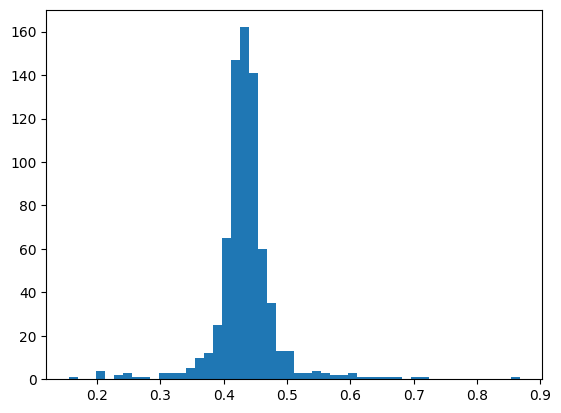

In [23]:
plt.hist(model.simu_indiv_params['riskCoef'],bins=50)

(array([  1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   1.,   5.,   0.,   2.,   2.,   3.,   1.,
         10.,   7.,  11.,  12.,  29.,  56.,  88., 130., 156.,  85.,  45.,
         26.,  17.,   9.,  11.,   3.,   2.,   6.,   1.,   3.,   0.,   3.,
          0.,   3.,   2.,   1.,   1.,   2.]),
 array([0.25889793, 0.26563063, 0.27236333, 0.27909603, 0.28582873,
        0.29256143, 0.29929413, 0.30602683, 0.31275953, 0.31949223,
        0.32622494, 0.33295764, 0.33969034, 0.34642304, 0.35315574,
        0.35988844, 0.36662114, 0.37335384, 0.38008654, 0.38681924,
        0.39355194, 0.40028464, 0.40701734, 0.41375004, 0.42048274,
        0.42721544, 0.43394814, 0.44068084, 0.44741354, 0.45414624,
        0.46087894, 0.46761164, 0.47434434, 0.48107704, 0.48780974,
        0.49454244, 0.50127514, 0.50800784, 0.51474054, 0.52147324,
        0.52820594, 0.53493864, 0.54167134, 0.54840404, 0.55513674,
        0.56186944, 0.56860214, 0.57533484, 0.

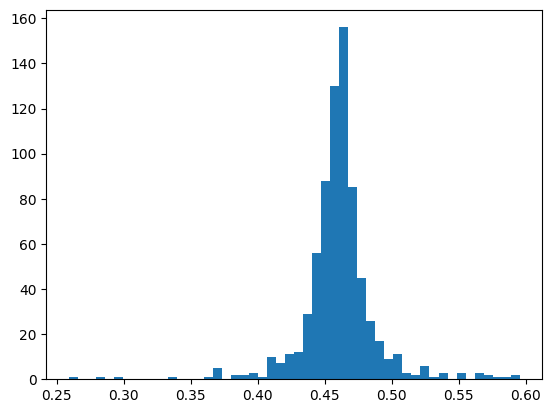

In [24]:
plt.hist(model.simu_indiv_params['probW'],bins=50)

(array([  1.,   0.,   0.,   0.,   2.,   2.,   1.,   1.,   4.,   0.,   0.,
          1.,   4.,   2.,   6.,   4.,   7.,   8.,  19.,  32.,  38.,  69.,
         98.,  95., 115.,  86.,  44.,  26.,  21.,  13.,   6.,   9.,   8.,
          2.,   1.,   2.,   1.,   1.,   2.,   1.,   1.,   1.,   0.,   1.,
          0.,   0.,   0.,   1.,   0.,   1.]),
 array([0.51168028, 0.54464209, 0.57760389, 0.6105657 , 0.64352751,
        0.67648931, 0.70945112, 0.74241293, 0.77537474, 0.80833654,
        0.84129835, 0.87426016, 0.90722197, 0.94018377, 0.97314558,
        1.00610739, 1.0390692 , 1.072031  , 1.10499281, 1.13795462,
        1.17091643, 1.20387823, 1.23684004, 1.26980185, 1.30276365,
        1.33572546, 1.36868727, 1.40164908, 1.43461088, 1.46757269,
        1.5005345 , 1.53349631, 1.56645811, 1.59941992, 1.63238173,
        1.66534354, 1.69830534, 1.73126715, 1.76422896, 1.79719077,
        1.83015257, 1.86311438, 1.89607619, 1.92903799, 1.9619998 ,
        1.99496161, 2.02792342, 2.06088522, 2.

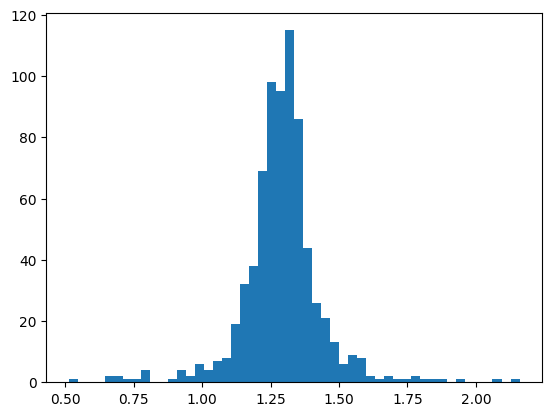

In [330]:
plt.hist(model.simu_indiv_params['temp'],bins=50)

In [32]:
# model = pickle.load(open('ProbWeigh_normal_new.pkl', 'rb'))
# df_equity['riskCoef'] = model.simu_indiv_params['riskCoef']
# df_equity['probW'] = model.simu_indiv_params['probW']
# df_equity['temp'] = model.simu_indiv_params['temp']


model = pickle.load(open('models_prob_weigh/pw_class_5.pkl', 'rb'))
df_equity['class_probW'] = (model.post_prob * model.latent_class['probW']).sum(axis=1)
df_equity['class_riskCoef'] = (model.post_prob * model.latent_class['riskCoef']).sum(axis=1)
# df_equity['class_temp'] = (model.post_prob * model.latent_class['temp']).sum(axis=1)
# df_equity['class_prob'] = model.post_prob[:,0]

df_reg_normal = pd.merge(left=df_reg,right=df_equity[['prim_key','weight','class_probW','class_riskCoef']],
                        on=['prim_key','weight'])

endog = df_reg_normal['ratio_indiv_stock']

new_exog_cols = [x for x in exog_cols if x not in ['inverse_S','riskaversion']]

# exog = sm.add_constant(df_reg_normal[['probW','riskCoef','temp'] + new_exog_cols])
exog = sm.add_constant(df_reg_normal[['class_probW','class_riskCoef'] + new_exog_cols])

# exog = sm.add_constant(df_reg_normal[['inverse_S','riskaversion'] + exog_cols])

reg_result = sm.WLS(endog, exog,weights=df_reg_normal['weight']).fit()

reg_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:      ratio_indiv_stock   R-squared:                       0.120
Model:                            WLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     4.899
Date:                Tue, 21 Jan 2025   Prob (F-statistic):           2.23e-11
Time:                        16:08:47   Log-Likelihood:                -456.61
No. Observations:                 737   AIC:                             955.2
Df Residuals:                     716   BIC:                             1052.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3358      0.129      2.603      0.009       0.082       0.589
class_probW           -0.1369      0.050     -2.738      0.006      -0.235      -0.039
class_riskCoef         0.1183      0.062      1.922      0.055      -0.003       0.239
age                    0.0061      0.006      0.999      0.318      -0.006       0.018
age2               -5.575e-05   5.91e-05     -0.943      0.346      -0.000    6.03e-05
male                   0.0717      0.031      2.326      0.020       0.011       0.132
married               -0.0351      0.036     -0.967      0.334      -0.106       0.036
white                 -0.1223      0.048     -2.531      0.012      -0.217      -0.027
hispanic               0.1092      0.065      1.686      0.092      -0.018       0.236
employed              -0.0434      0.045     -0.972      0.331      -0.131       0.044
householdmembers      -0.0136      0.014     -0.946      0.345      -0.042       0.015
no_college_degree      0.1638      0.048      3.382      0.001       0.069       0.259
bachelor_degree        0.1341      0.047      2.847      0.005       0.042       0.227
master_degree          0.0379      0.050      0.763      0.446      -0.060       0.135
familyincome_value     0.0515      0.020      2.635      0.009       0.013       0.090
fin_wealth            -0.0318      0.008     -3.892      0.000      -0.048      -0.016
fin_literacy          -0.0140      0.017     -0.838      0.402      -0.047       0.019
numeracy               0.0393      0.014      2.735      0.006       0.011       0.067
trust                  0.0320      0.015      2.130      0.033       0.003       0.062
optimism              -0.0369      0.011     -3.222      0.001      -0.059      -0.014
gambling               0.0158      0.030      0.523      0.601      -0.043       0.075
missing_value          0.0065      0.045      0.144      0.885      -0.082       0.095
==============================================================================
Omnibus:                        4.126   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.127   Jarque-Bera (JB):                3.340
Skew:                          -0.054   Prob(JB):                        0.188
Kurtosis:                       2.688   Cond. No.                     2.20e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.44e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [40]:
reg_result = smf.wls('inverse_S ~ class_probW + class_riskCoef + class_temp', 
                     data=df_reg_normal, weights=df_reg_normal['weight'])

reg_result.fit().summary()

d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is de

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:              inverse_S   R-squared:                       0.324
Model:                            WLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     117.3
Date:                Fri, 17 Jan 2025   Prob (F-statistic):           4.99e-62
Time:                        13:35:04   Log-Likelihood:                -792.25
No. Observations:                 737   AIC:                             1592.
Df Residuals:                     733   BIC:                             1611.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.0483      0.137      7.634      0.000       0.779       1.318
class_probW       -2.3700      0.564     -4.200      0.000      -3.478      -1.262
class_riskCoef     0.8116      0.193      4.205      0.000       0.433       1.191
class_temp        -0.0355      0.017     -2.089      0.037      -0.069      -0.002
==============================================================================
Omnibus:                      205.296   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2505.146
Skew:                           0.885   Prob(JB):                         0.00
Kurtosis:                      11.857   Cond. No.                         348.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
df_reg_normal['rank_probW'] = df_reg_normal['class_probW'].rank(ascending=False, method='min') / len(df_reg_normal)
df_reg_normal['rank_riskCoef'] = df_reg_normal['class_riskCoef'].rank(ascending=False, method='min') / len(df_reg_normal)
df_reg_normal['rank_temp'] = df_reg_normal['class_temp'].rank(ascending=False, method='min') / len(df_reg_normal)

reg_result = smf.wls('inverse_S ~ rank_probW + rank_riskCoef + rank_temp', 
                     data=df_reg_normal, weights=df_reg_normal['weight'])

reg_result.fit().summary()

d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
d:\Python\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is de

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:              inverse_S   R-squared:                       0.321
Model:                            WLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     115.4
Date:                Fri, 17 Jan 2025   Prob (F-statistic):           3.34e-61
Time:                        13:35:12   Log-Likelihood:                -794.17
No. Observations:                 737   AIC:                             1596.
Df Residuals:                     733   BIC:                             1615.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0134      0.059     -0.228      0.820      -0.129       0.102
rank_probW        0.9285      0.196      4.746      0.000       0.544       1.313
rank_riskCoef    -0.7248      0.203     -3.571      0.000      -1.123      -0.326
rank_temp         0.8036      0.307      2.618      0.009       0.201       1.406
==============================================================================
Omnibus:                      186.035   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2428.259
Skew:                           0.742   Prob(JB):                         0.00
Kurtosis:                      11.768   Cond. No.                         25.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
df_reg_normal.iloc[:, ::-1].corr(numeric_only=True)

,class_temp,class_riskCoef,class_probW,missing_value,gambling,optimism,trust,numeracy,fin_literacy,fin_wealth,...,hispanic,white,married,male,age2,age,riskaversion,inverse_S,ratio_indiv_stock,weight
class_temp,1.000000,0.872756,0.863692,-0.094160,0.010804,-0.005625,-0.071559,-0.060154,-0.041519,0.008339,...,0.042936,-0.065787,0.047961,0.002696,-0.037183,-0.042789,-0.780209,-0.391941,-0.061012,0.007896
class_riskCoef,0.872756,1.000000,0.557175,-0.099147,0.067736,0.012682,-0.092160,-0.052590,-0.013498,-0.007710,...,0.050650,-0.074260,0.056668,0.020040,-0.105655,-0.106473,-0.867442,-0.145534,-0.046742,0.003155
class_probW,0.863692,0.557175,1.000000,-0.094818,-0.026231,-0.026722,-0.055904,-0.042523,-0.046612,0.017776,...,0.017442,-0.031412,0.035107,0.006366,0.034428,0.027828,-0.487003,-0.537369,-0.071009,0.009188
missing_value,-0.094160,-0.099147,-0.094818,1.000000,-0.057053,-0.039674,0.159738,-0.003673,-0.015335,-0.015549,...,-0.022280,0.000129,-0.210510,-0.012679,0.372226,0.348798,0.071621,-0.001285,0.030227,-0.007133
gambling,0.010804,0.067736,-0.026231,-0.057053,1.000000,-0.026884,0.051526,0.008562,-0.063067,-0.026790,...,0.063158,-0.039927,0.113847,0.068966,-0.119432,-0.113259,-0.031900,0.050958,0.072094,0.053782
optimism,-0.005625,0.012682,-0.026722,-0.039674,-0.026884,1.000000,-0.064603,0.042626,0.055704,-0.016684,...,0.031189,-0.182211,-0.026336,0.136648,-0.125265,-0.137464,0.015452,0.046454,-0.007182,0.119330
trust,-0.071559,-0.092160,-0.055904,0.159738,0.051526,-0.064603,1.000000,-0.081529,-0.076617,0.043519,...,0.070642,-0.088521,-0.098554,0.035680,0.069938,0.063577,0.051961,0.027545,0.029433,0.016858
numeracy,-0.060154,-0.052590,-0.042523,-0.003673,0.008562,0.042626,-0.081529,1.000000,-0.006260,0.010658,...,0.012939,0.050740,0.045591,0.067777,-0.066633,-0.060889,0.044220,0.034955,0.073253,-0.010454
fin_literacy,-0.041519,-0.013498,-0.046612,-0.015335,-0.063067,0.055704,-0.076617,-0.006260,1.000000,0.018225,...,0.019818,0.014896,0.050014,0.075788,0.012782,0.014851,0.052496,0.046886,-0.039292,0.004658
fin_wealth,0.008339,-0.007710,0.017776,-0.015549,-0.026790,-0.016684,0.043519,0.010658,0.018225,1.000000,...,-0.041285,0.042535,0.069851,-0.034468,0.064235,0.070636,-0.019286,-0.027961,-0.088871,0.041185


(array([ 53.,  12.,  15., 150., 230.,  56.,  29.,  30.,  13.,   9.,  15.,
         10.,   7.,   5.,  11.,   5.,   7.,   6.,   5.,   8.,   3.,   4.,
          3.,   2.,   1.,   4.,   8.,   2.,   6.,  28.]),
 array([1.88127999e-07, 3.06760323e-02, 6.13518765e-02, 9.20277206e-02,
        1.22703565e-01, 1.53379409e-01, 1.84055253e-01, 2.14731097e-01,
        2.45406941e-01, 2.76082786e-01, 3.06758630e-01, 3.37434474e-01,
        3.68110318e-01, 3.98786162e-01, 4.29462007e-01, 4.60137851e-01,
        4.90813695e-01, 5.21489539e-01, 5.52165383e-01, 5.82841227e-01,
        6.13517072e-01, 6.44192916e-01, 6.74868760e-01, 7.05544604e-01,
        7.36220448e-01, 7.66896292e-01, 7.97572137e-01, 8.28247981e-01,
        8.58923825e-01, 8.89599669e-01, 9.20275513e-01]),
 <BarContainer object of 30 artists>)

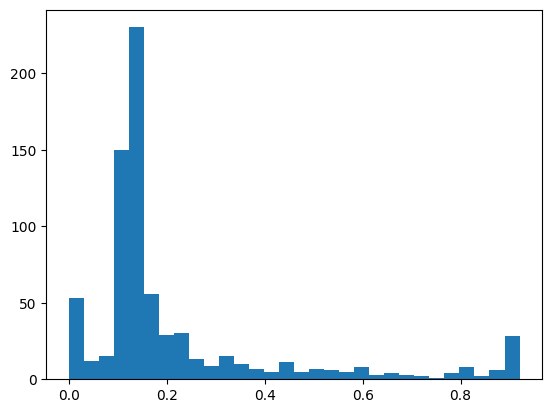

In [518]:
plt.hist(df_equity['class_probW'],bins=30)

(array([ 10.,  16.,  34., 198.,  19.,  13.,   8.,   6.,  10.,   6.,   2.,
          8.,   5.,   9.,   4.,   5.,   5.,   4.,   2.,   8.,   7.,   6.,
          7.,   7.,   7.,  16.,  16.,  18.,  70., 211.]),
 array([0.04714923, 0.07891093, 0.11067262, 0.14243431, 0.174196  ,
        0.20595769, 0.23771938, 0.26948107, 0.30124276, 0.33300445,
        0.36476614, 0.39652783, 0.42828952, 0.46005122, 0.49181291,
        0.5235746 , 0.55533629, 0.58709798, 0.61885967, 0.65062136,
        0.68238305, 0.71414474, 0.74590643, 0.77766812, 0.80942981,
        0.84119151, 0.8729532 , 0.90471489, 0.93647658, 0.96823827,
        0.99999996]),
 <BarContainer object of 30 artists>)

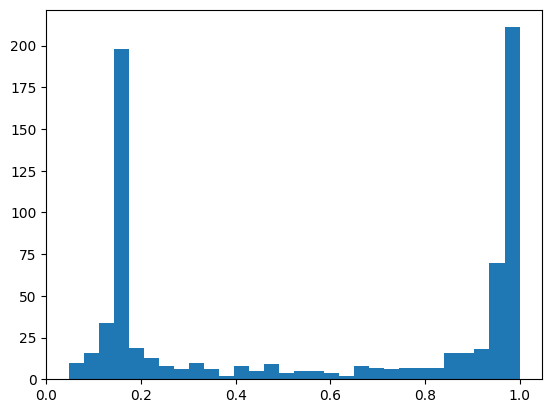

In [519]:
plt.hist(df_equity['class_riskCoef'],bins=30)

(array([275.,  22.,  53.,  24.,  16.,  13.,  10.,  10.,  12.,  15.,  12.,
         29.,  82.,  20.,  18.,  10.,   3.,   8.,  10.,   7.,   7.,   7.,
          4.,   4.,   1.,   6.,   5.,   8.,  12.,  34.]),
 array([ 0.44257511,  0.99525017,  1.54792523,  2.10060028,  2.65327534,
         3.2059504 ,  3.75862546,  4.31130051,  4.86397557,  5.41665063,
         5.96932569,  6.52200074,  7.0746758 ,  7.62735086,  8.18002592,
         8.73270098,  9.28537603,  9.83805109, 10.39072615, 10.94340121,
        11.49607626, 12.04875132, 12.60142638, 13.15410144, 13.70677649,
        14.25945155, 14.81212661, 15.36480167, 15.91747672, 16.47015178,
        17.02282684]),
 <BarContainer object of 30 artists>)

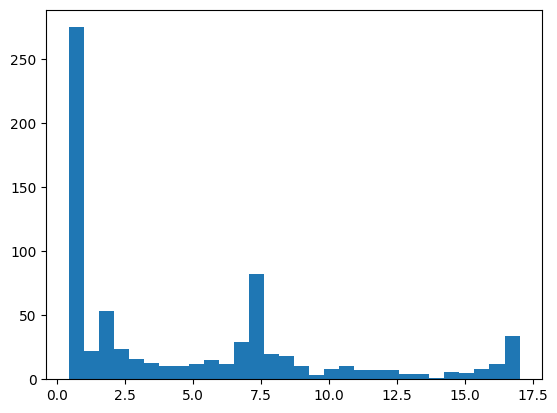

In [520]:
plt.hist(df_equity['class_temp'],bins=30)